# 최종4. 모델을 이용해서 Noise 제거 (시행착오)
### 목표: 정상 데이터에 Noise를 추가해서 학습하고, KNN으로 Noise 제거하도록 학습
### 추가문제 발생: Noise 제거기 학습 어떻게? + 정확도 낮음 -> So, Expired

## Summary:
- 시간도 오래 걸리고, Score도 낮고, 메모리 및 전력 사용량도 기대 할 만큼 좋지 않음
- Shifted, Noised에 대해서는 Computer Vision의 영역으로 넘기기 -> 최대한 함수로 해결해보자는 결론

# Index
### 1. Library Import + Function Definition for 학습
### 2. Noise 제거기 학습
### 3. Noise 제거기 작동 Test
### 4. Noise 제거기를 Pipeline에 추가했을 때 Score 비교

## 1. Library Import + Function Definition for 학습

In [1]:
# import library for 학습
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

from sklearn import datasets
import time

from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2

In [2]:
def center_image(image):
    img_reshaped = image.reshape(28, 28)
    non_empty_rows = np.where(img_reshaped.any(axis=1))[0]
    non_empty_cols = np.where(img_reshaped.any(axis=0))[0]

    # 예외 처리: 이미지에 아무것도 없는 경우 pass
    if len(non_empty_rows) == 0 or len(non_empty_cols) == 0:
        return img_reshaped.reshape(-1)

    top, bottom = non_empty_rows[0], non_empty_rows[-1]
    left, right = non_empty_cols[0], non_empty_cols[-1]
    center_y, center_x = (top + bottom) // 2, (left + right) // 2
    shift_y, shift_x = 14 - center_y, 14 - center_x
    shifted_img = np.roll(img_reshaped, shift_x, axis=1)
    shifted_img = np.roll(shifted_img, shift_y, axis=0)
    return shifted_img.reshape(-1)

In [3]:
def enlarge_image_to_square(image):
    img_reshaped = image.reshape(28, 28)
    non_empty_rows = np.where(img_reshaped.any(axis=1))[0]
    non_empty_cols = np.where(img_reshaped.any(axis=0))[0]

    # 이미지에 아무것도 없는 경우 28x28의 빈 이미지로 확장
    if len(non_empty_rows) == 0 or len(non_empty_cols) == 0:
        enlarged_image = np.zeros((28, 28), dtype=np.uint8)
        return enlarged_image.flatten()

    # 가장 작은 정사각형의 좌표 찾기
    top, bottom = non_empty_rows[0], non_empty_rows[-1]
    left, right = non_empty_cols[0], non_empty_cols[-1]
    width = right - left + 1
    height = bottom - top + 1

    # 가장 작은 정사각형 생성
    max_side = max(width, height)
    square_image = np.zeros((max_side, max_side), dtype=np.uint8)
    start_row = (max_side - height) // 2
    start_col = (max_side - width) // 2
    square_image[start_row:start_row + height, start_col:start_col + width] = img_reshaped[top:bottom + 1, left:right + 1]

    # 정사각형 이미지를 28x28로 resize
    enlarged_image = Image.fromarray(square_image.astype('uint8'))
    enlarged_image = enlarged_image.resize((28, 28), Image.BICUBIC)

    # 확대된 이미지를 배열로 변환
    enlarged_data = np.array(enlarged_image).flatten()

    return enlarged_data

In [4]:
from sklearn.base import TransformerMixin

# 이미지를 중앙화하는 변환기 클래스 정의
class ImageCenteringTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # 이 경우에는 학습이 필요 없으므로 fit 메서드에서 아무 작업도 하지 않습니다.
        return self

    def transform(self, X):
        return np.apply_along_axis(center_image, 1, X)

# 이미지를 정사각형으로 확대하는 변환기 클래스 정의
class ImageEnlargingTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # 이 경우에도 학습이 필요 없으므로 fit 메서드에서 아무 작업도 하지 않습니다.
        return self

    def transform(self, X):
        return np.apply_along_axis(enlarge_image_to_square, 1, X)

In [5]:
def noise_add(X):
    # Calculate the maximum value for each image along the axis of the pixels (axis=1)
    max_vals = np.max(X, axis=1, keepdims=True)
    
    # Generate noise based on the maximum value of each image
    noise = np.random.uniform(0, max_vals * (1/2), size=X.shape)
    
    # Add noise to the original data
    noisy_data = X + noise
    return noisy_data

## 2-1. Noise 제거기 학습

In [6]:
import pickle
filename = 'Handmade_Perfect_Data_with_MNIST.pkl'
with open(filename, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

N_X_train = noise_add(X_train)
C_X_train = X_train

knn_denoiser = KNeighborsClassifier(n_neighbors=3)
knn_denoiser.fit(N_X_train , C_X_train)  # Train KNN on clean and noisy data

KNeighborsClassifier(n_neighbors=3)

## 2-2. Noise 제거기 정의 
## [Parameter로 데이터 넘기기 -> out of memory 문제 발생 // 데이터 6만개 일때 불가능]

In [7]:
def denoise_with_knn(X):
    # Assuming X_clean is the clean data
    # Predict clean data from noisy data
    denoised_X = knn_denoiser.predict(X)
    return denoised_X

## 3. Noise 제거기 작동 Test

### 3-1. 이미지 출력함수

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_by_label(X, y, num_samples=10):
    unique_labels = np.unique(y)
    
    for label in unique_labels:
        label_indices = np.where(y == label)[0][:num_samples]
        
        plt.figure(figsize=(15, 1.5))
        for i, index in enumerate(label_indices):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(X[index].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Label {label}', y=1.1)
        plt.show()

### 3-2. Noise 제거기 통과한 이미지 출력

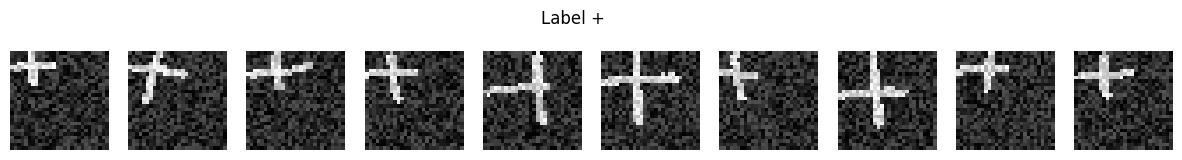

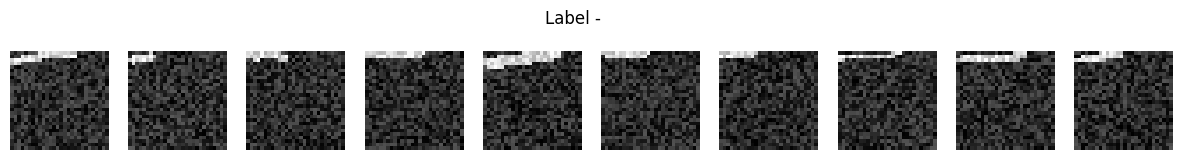

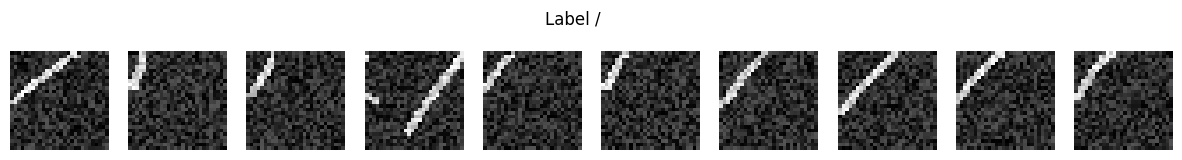

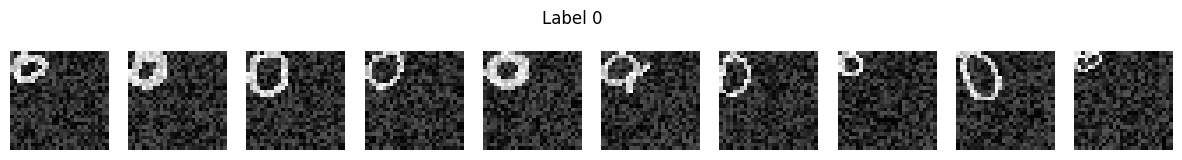

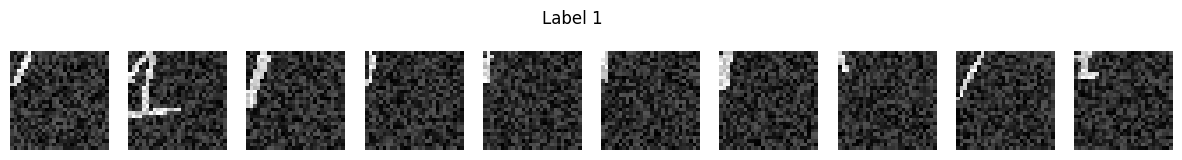

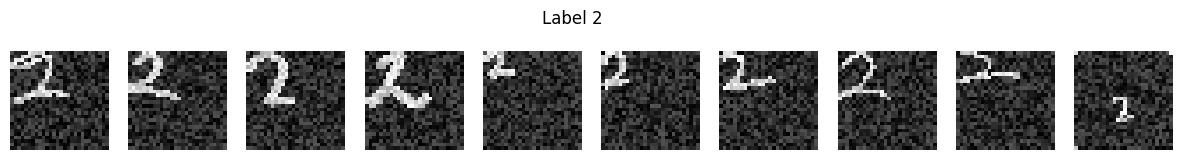

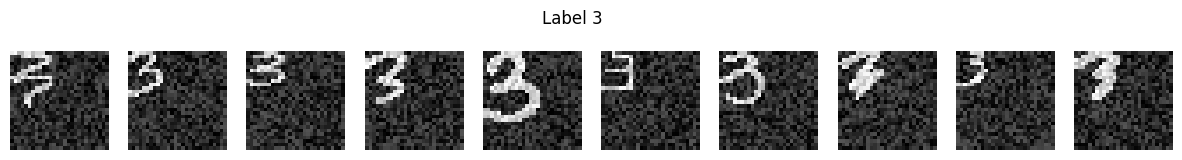

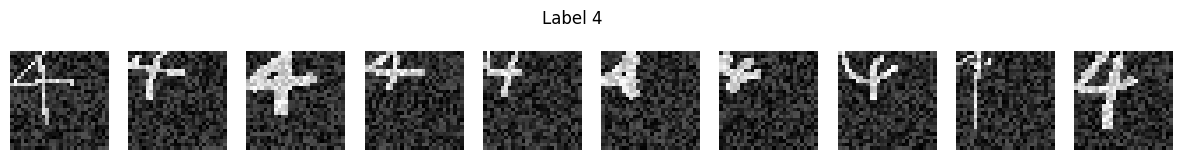

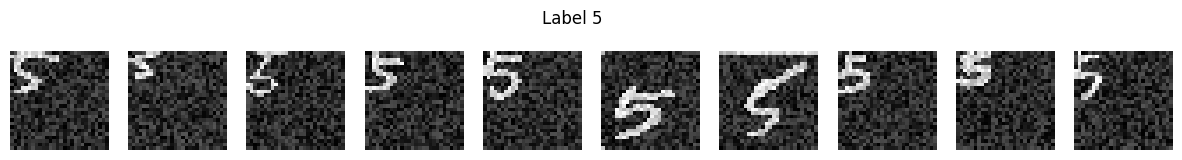

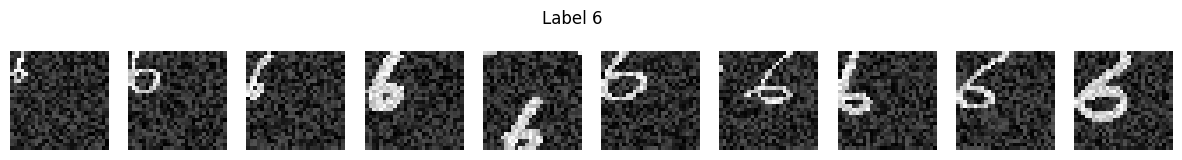

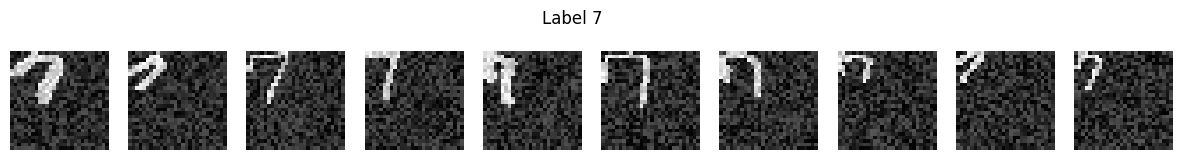

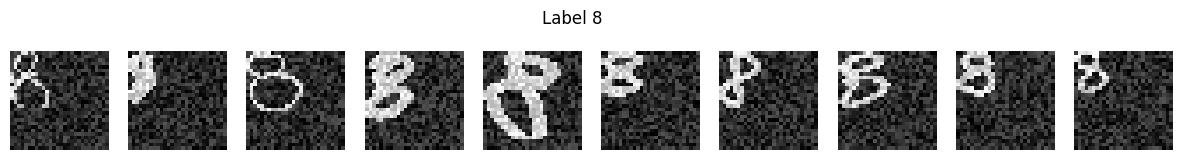

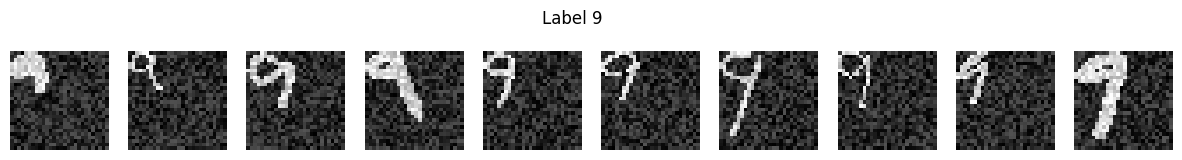

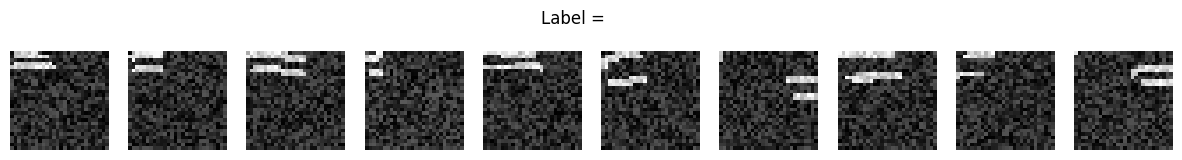

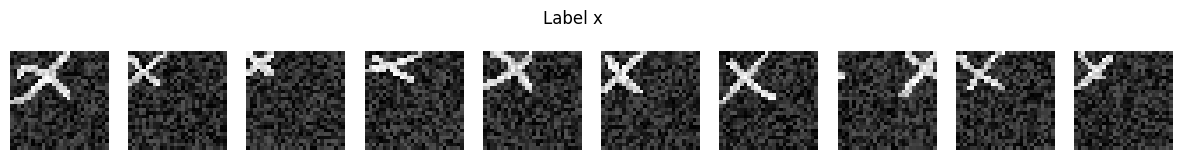

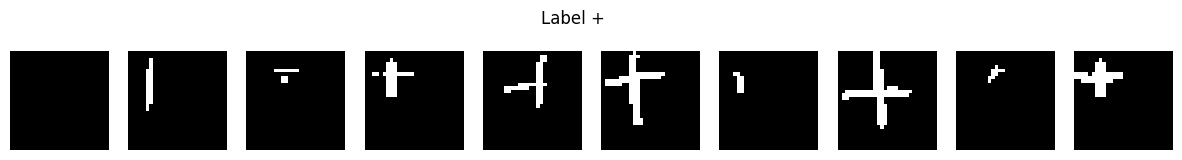

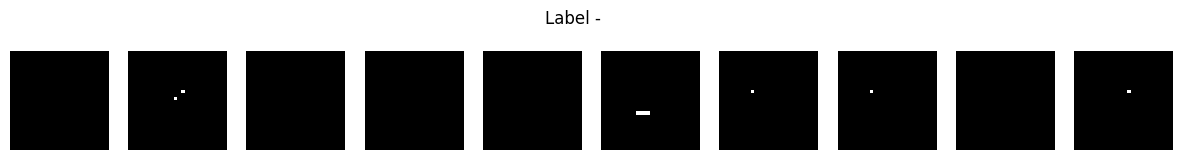

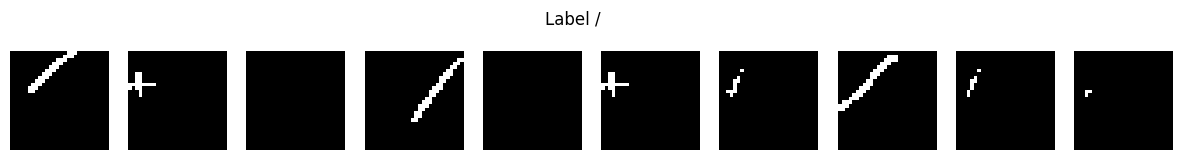

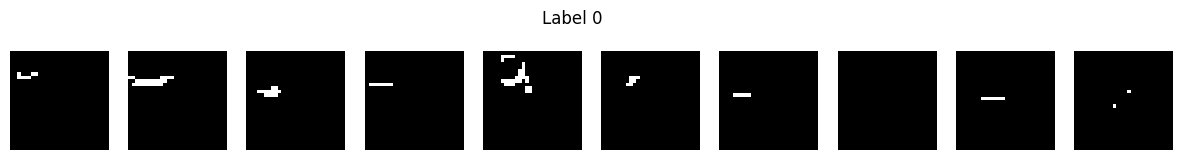

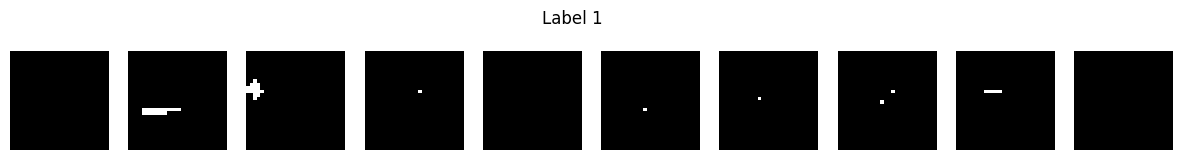

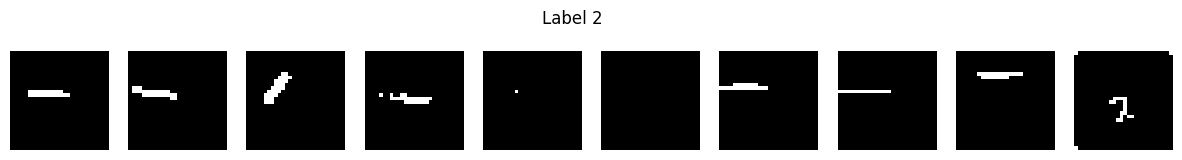

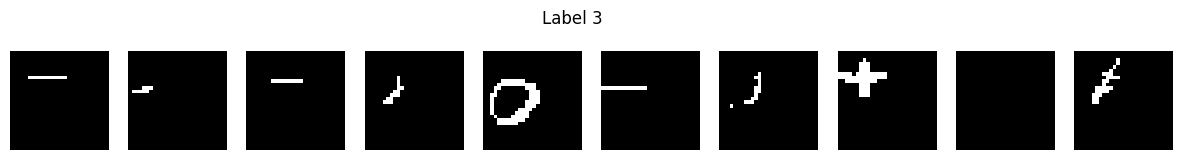

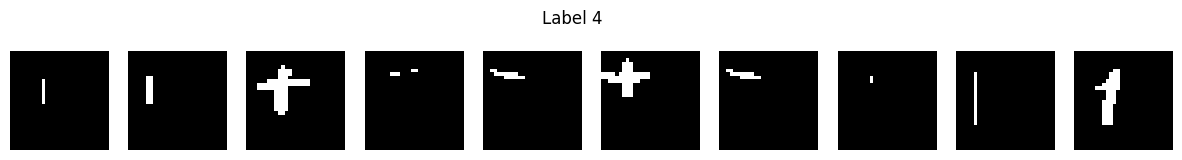

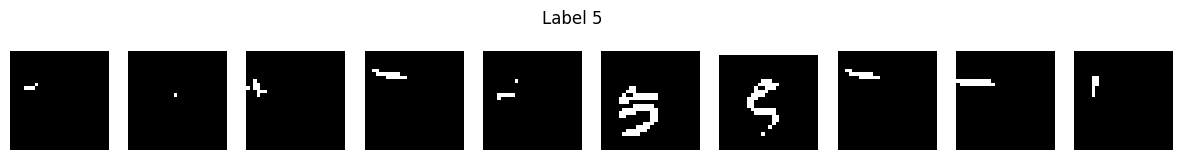

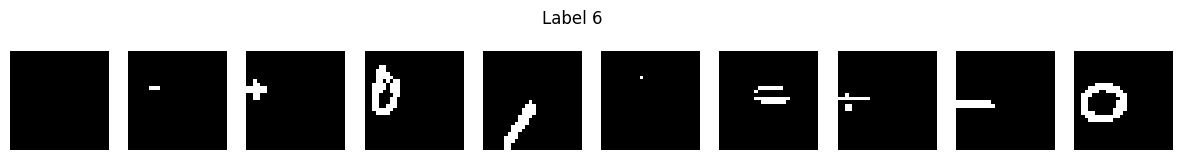

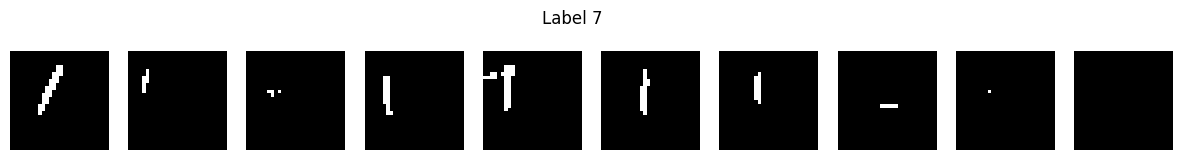

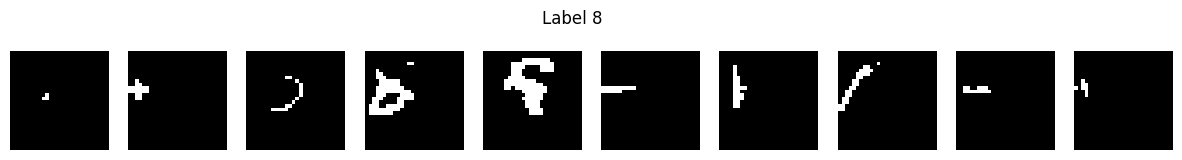

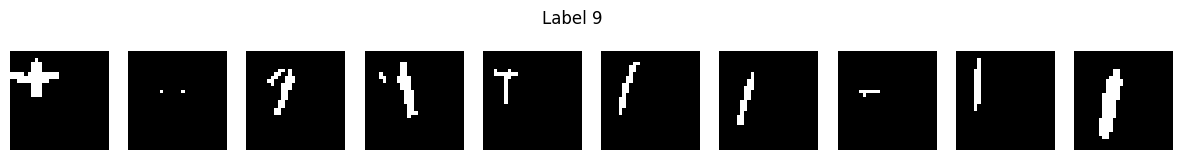

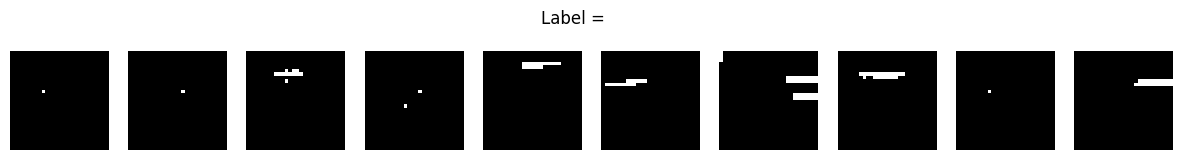

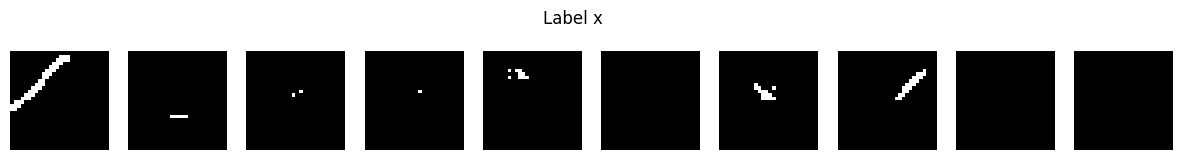

In [9]:
filename = 'Quarter_Noised_Shifted_Handmade_Perfect_Data_with_MNIST.pkl'
with open(filename, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

show_images_by_label(X_train, y_train)
X_train = denoise_with_knn(X_train)
show_images_by_label(X_train, y_train)

## 4. Noise 제거기를 Pipeline에 추가했을 때 Score 비교
- 시간도 오래 걸리고, Score도 낮고, 메모리 및 전력 사용량도 기대 할 만큼 좋지 않음
- Shifted, Noised에 대해서는 Computer Vision의 영역으로 넘기기 -> 최대한 함수로 해결해보자는 결론

In [10]:
import pickle
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
import time

# Define a function to remove noise using KNN

filename = 'Quarter_Noised_Shifted_Handmade_Perfect_Data_with_MNIST.pkl'
with open(filename, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

clean_X_train =  X_train
clean_X_test =  X_test

knn_pipeline = Pipeline([
    ('denoise', FunctionTransformer(denoise_with_knn)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', ImageEnlargingTransformer()),  # 이미지 정사각형으로 확대
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('knn', KNeighborsClassifier())  # KNN 모델
])

# Measure the time taken for training
start_time = time.time()
knn_pipeline.fit(clean_X_train, y_train)  # Train on clean data
end_time = time.time()
print(f"KNN Training time: {end_time - start_time} seconds")
# Calculate accuracy on test data
start_time = time.time()
accuracy = knn_pipeline.score(clean_X_test, y_test)  # Evaluate on clean test data
end_time = time.time()
print(f"KNN Predict time: {end_time - start_time} seconds")
print("KNN accuracy with denoising using Pipeline: ", accuracy)

KNN Training time: 32.306952238082886 seconds
KNN Predict time: 3.1753671169281006 seconds
KNN accuracy with denoising using Pipeline:  0.29858585858585857


In [11]:
import pickle
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
import time

# Define a function to remove noise using KNN

filename = 'Quarter_Noised_Shifted_Handmade_Perfect_Data_with_MNIST.pkl'
with open(filename, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

clean_X_train =  X_train
clean_X_test =  X_test

knn_pipeline = Pipeline([
    #('denoise', FunctionTransformer(denoise_with_knn)),  # Denoising step
    ('image_centering', ImageCenteringTransformer()),  # 이미지 중앙화
    ('image_enlarging', ImageEnlargingTransformer()),  # 이미지 정사각형으로 확대
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('knn', KNeighborsClassifier())  # KNN 모델
])

# Measure the time taken for training
start_time = time.time()
knn_pipeline.fit(clean_X_train, y_train)  # Train on clean data
end_time = time.time()
print(f"KNN Training time: {end_time - start_time} seconds")
# Calculate accuracy on test data
start_time = time.time()
accuracy = knn_pipeline.score(clean_X_test, y_test)  # Evaluate on clean test data
end_time = time.time()
print(f"KNN Predict time: {end_time - start_time} seconds")
print("KNN accuracy with denoising using Pipeline: ", accuracy)

KNN Training time: 1.3157997131347656 seconds
KNN Predict time: 0.5017943382263184 seconds
KNN accuracy with denoising using Pipeline:  0.806060606060606


# [EOF]